In [1]:
from Calibration import *

## Load forcing data

In [3]:
forcing = pd.read_csv('Data/ThunderCreek/forcing_thundercreek.csv', index_col=[0], parse_dates=True)
pd.to_datetime(forcing.index);
forcing = forcing.reset_index(level=0)
for i in range(len(forcing)):
    forcing['time'][i] = forcing['time'][i].date()
forcing.set_index('time', inplace=True)

C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Setting up the model

In [4]:
model = BMI_HBVmountain()

In [5]:
config_file = model.setup()

In [6]:
model.initialize(config_file)

### Parameters

In [10]:
bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters, parameters_array =  Main.parameter_selection()
model.set_value('bare_parameters', bare_parameters)
model.set_value('forest_parameters', forest_parameters)
model.set_value('grass_parameters', grass_parameters)
model.set_value('rip_parameters', rip_parameters)
model.set_value('slow_parameters', slow_parameters)

In [11]:
# param_list = parameter_conversion('output_tc', nsmallest=10)

# model.set_value('bare_parameters', param_list[0][0])
# model.set_value('forest_parameters', param_list[0][1])
# model.set_value('grass_parameters', param_list[0][2])
# model.set_value('rip_parameters', param_list[0][3])
# model.set_value('slow_parameters', param_list[0][4])


### Forcings

In [12]:
model.set_value('Temperature', (forcing['temp_era5'].values).reshape(len(forcing),1))
model.set_value('Precipitation', (forcing['prec_era5'].values).reshape(len(forcing),1))

model.set_value('Date', list(forcing.index.values))
model.set_value('Current_Date', forcing.index.values[0])

### Initial settings

In [13]:
model.set_value('Elevation', Elevations(500, 500, 2500, 1500, 1500)) # 4 Elevation bands

model.set_value('Glacier', [0.0, 0.0, 0.0, 0.6]) # 60% of the area glacier at highest elevation band
model.set_value('Sunhours', [8.87, 10.30, 11.88, 13.65, 15.13, 15.97, 15.58, 14.25, 12.62, 11.87, 9.28, 8.45]) #Seattle
model.set_value('bare_input', HRU_Input([0.0,0.0,0.3,0.7], 0.32, [0.0, 0.0, 0.0, 0.6], [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('forest_input', HRU_Input([0.0,0.7,0.3,0.0], 0.45,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('grass_input', HRU_Input([0.7,0.3,0.0,0.0], 0.21,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('rip_input', HRU_Input([1.0,0.0,0.0,0.0], 0.02,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('Total_Elevationbands', 4)
model.set_value('Elevation_Percentage', [0.15,0.26,0.36,0.23])
model.set_value('bare_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('forest_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('grass_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('rip_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

## Running the model

In [14]:
Discharge = []
timestamp = []
while (model.get_value_ptr('Current_Date') < (datetime.date(1999, 1, 1))):  
    model.update()
    timestamp.append(model.get_value_ptr('Current_Date'))
    Discharge.append(model.get_value_ptr('Discharge'))

## Analysis

In [15]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': Discharge},
    index=pd.to_datetime(timestamp)
)
combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)
combined_discharge

,simulation,streamflow
1986-01-02,0.000000,0.971722
1986-01-03,0.000000,0.953927
1986-01-04,0.000000,0.944712
1986-01-05,0.000000,0.944712
1986-01-06,0.000000,0.962825
...,...,...
1998-12-28,1.650848,3.302202
1998-12-29,3.488525,6.505580
1998-12-30,7.042474,8.332087
1998-12-31,5.385914,6.001606


## Clean up

In [17]:
model.finalize()

In [18]:
print(model)

In [4]:
generate_landuse_per_elevation('Data/dem_thundercreek.tif', 'Data/nlcd_thundercreek.tif')

[[[0.15, 0.312, 0.416, 0.122],
  [0.317, 0.456, 0.214, 0.013],
  587.5,
  396.0,
  2746.0,
  1572.355],
 [[0.001, 0.067, 0.706, 0.227], [0.0, 0.021, 0.224, 0.072]],
 [[0.001, 0.083, 0.636, 0.28]],
 [[0.217, 0.396, 0.368, 0.02]],
 [[0.077, 0.263, 0.546, 0.114]],
 [[0.65, 0.096, 0.232, 0.023]]]

In [7]:
bounds = gpd.read_file('Data/Shapes/Thundercreek.shp').bounds

In [9]:
west, south, east, north = bounds = bounds.loc[0]

In [10]:
west, south, east, north = bounds  = west - .05, south - .05, east + .05, north + .05

In [33]:
import elevation

In [34]:
dem_path = 'ThunderCreek_DEM.tif'
output = os.getcwd() + dem_path

In [42]:
# elevation.clip(bounds=bounds, output=dem_path, product='SRTM3')

In [114]:
# from elevation import cli
# cli.selfcheck()

In [83]:
soa_shape_map_path = "Data/Shapes/Thundercreek.shp"
soa_shape_map = gpd.read_file(soa_shape_map_path)

# soa_shape_map_geo = soa_shape_map.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
# print(soa_shape_map.iloc[0].geometry.centroid.x, soa_shape_map_geo.iloc[0].geometry.centroid.y)


ERROR:fiona._env:PROJ: proj_identify: C:\Users\Vincent Hoogelander\anaconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [66]:
lon, lat = soa_shape_map_geo.iloc[0].geometry.centroid.x, soa_shape_map_geo.iloc[0].geometry.centroid.y

In [63]:
from suntime import Sun, SunTimeException

In [80]:
sun = Sun(lat, lon)

In [81]:
abd = datetime.date(2005, 12, 14)
abd_sr = sun.get_local_sunrise_time(abd)
abd_ss = sun.get_local_sunset_time(abd)

In [82]:
(abd_ss - abd_sr).seconds / 3600

8.316666666666666

In [111]:
def get_monthly_sunhours(lat, lon):
    sunhours = []
    sun = Sun(lat, lon)
    for i in range(1,13):
        timedelta = sun.get_local_sunset_time(datetime.date(2005, i, 14)) - sun.get_local_sunrise_time(datetime.date(2005, i, 14))
        sunhours.append(np.round(timedelta.seconds / 3600,2))
    return sunhours

In [112]:
get_monthly_sunhours(lat, lon)

[8.72, 10.17, 11.8, 13.63, 15.2, 16.08, 15.75, 14.42, 12.67, 10.9, 9.25, 8.32]

In [123]:
# from rasterio.warp import calculate_default_transform, reproject, Resampling

# dst_crs = 'EPSG:4326'

# with rasterio.open('Data/NLCD_2001_Landuse.tif') as src:
#     transform, width, height = calculate_default_transform(
#         src.crs, dst_crs, src.width, src.height, *src.bounds)
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': dst_crs,
#         'transform': transform,
#         'width': width,
#         'height': height
#     })

# with rasterio.open('/tmp/Data/NLCD_2001_Landuse.tif', 'w', **kwargs) as dst:
#     for i in range(1, src.count + 1):
#         reproject(
#             source=rasterio.band(src, i),
#             destination=rasterio.band(dst, i),
#             src_transform=src.transform,
#             src_crs=src.crs,
#             dst_transform=transform,
#             dst_crs=dst_crs,
#             resampling=Resampling.nearest)

In [3]:
import fiona
import rasterio
import rasterio.mask

with fiona.open("Data/Shapes/Thundercreek.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open("Data/NLCD_2001_Landuse.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [5]:
full_calibration(1, 20)

TypeError: wrapped_objective_function() missing 1 required positional argument: 'iterations'

In [8]:
out_image

# arr = out_image.read(masked=True)
arr = np.expand_dims(out_image.flatten(), 0).T
get_landuse_from_raster(arr)

[0.145, 0.209, 0.098, 0.006]

In [9]:
def generate_array_from_raster(str_path_to_rasterfile):
    raster = rasterio.open(str_path_to_rasterfile)
    arr = raster.read(masked=True)
    arr = np.expand_dims(arr.flatten(), 0).T
    
    return arr

def get_elevations_from_raster(raster_array_flattened, nbands):
   
    n, bins, patches = plt.hist(raster_array_flattened, bins=nbands)
    plt.close()
    tot_pixels = n.sum()
    av_elevation = round(raster_array_flattened.mean(),3)
    
    elevation_list = []
    for i in range(nbands):
        elevation_percentage = n[i] / tot_pixels
        elevation_list.append(round(elevation_percentage, 3))
    min_elevation = np.min(bins)
    max_elevation = np.max(bins)
    return elevation_list, bins, min_elevation, max_elevation, av_elevation
def get_landuse_from_raster(raster_array_flattened):
    n, bins, patches = plt.hist(raster_array_flattened, bins=np.arange(96))
    plt.close()
    
    tot_pixels = n.sum()
    
    bare = np.sum(n[[12, 22, 22, 24, 31]]) / tot_pixels 
    forest = np.sum(n[40:46]) / tot_pixels 
    grass = (np.sum(n[50:83])+ n[21]) /tot_pixels 
    rip = np.sum(n[[11, 90, 94]]) /tot_pixels  
    
    

    landuse_list = [round(bare,3), round(forest,3), round(grass,3), round(rip,3)] 
    return landuse_list

In [10]:
n, bins, patches = plt.hist(arr, bins=np.arange(96))
plt.close()

tot_pixels = n.sum()

bare = np.sum(n[[12, 22, 22, 24, 31]]) / tot_pixels 
forest = np.sum(n[40:46]) / tot_pixels 
grass = (np.sum(n[50:83])+ n[21]) /tot_pixels 
rip = np.sum(n[[11, 90, 94]]) /tot_pixels  



landuse_list = [round(bare,3), round(forest,3), round(grass,3), round(rip,3)] 

(array([3.77028e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.28000e+03, 3.62970e+04, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.22800e+03, 2.40000e+01, 2.30000e+01, 2.00000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 6.47800e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 4.78000e+02, 1.44380e+05, 2.58000e+02, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 4.46170e+04, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

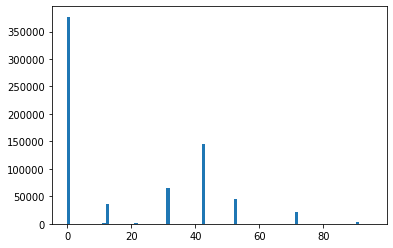

In [14]:
plt.hist(arr, bins=np.arange(96))